# RSM as sequential process for oprimisation 
(adapted from https://online.stat.psu.edu/stat503/lesson/11)


To find the maxima, we will use three different models

- Screening response model
- Steepest ascent model
- Optimization model 



In [83]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

## ## Screening Response Model
In the first place, we do not know if there is a maxima so we start somewhere where we think the optimim exists. We start somewhere in terms where x1 = reaction time (30-40 seconds) and x2 = temperature (150-160 C), and we want to maximize the yeld of a process as function of these factors.   

In [84]:
inputs_labels = {'t' : 'Time',
                 'T' : 'Temperature'}

#create list of data for high and low. 
dat = [('t',30,35,40),
        ('T',150,155,160)]

# create pandas dataframe in a pandas dataframe
inputs_df = pd.DataFrame(dat,columns=['index','low','center','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

#print dataframe
inputs_df

,low,center,high,label
index,,,,
t,30,35,40,Time
T,150,155,160,Temperature


In [85]:
# compute averages and span
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

# encode the data
inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_center'] = inputs_df.apply( lambda z : ( z['center'] - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,center,high,label,encoded_low,encoded_center,encoded_high
index,,,,,,,
t,30,35,40,Time,-1.0,0.0,1.0
T,150,155,160,Temperature,-1.0,0.0,1.0


In [86]:
import itertools
encoded_inputs= list(itertools.product([-1,1],[-1,1]))
encoded_inputs
for i in range(0,5):
    encoded_inputs.append((0,0))
encoded_inputs

[(-1, -1), (-1, 1), (1, -1), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]

In [87]:
results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['t','T']
results

,t,T
0,-1,-1
1,1,-1
2,-1,1
3,1,1
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0


In [88]:
def parse_values(x):
    if x < 2:
       return x * 10
    elif x < 4:
       return x ** 2
    else:
       return x + 10

real_experiment = results
var_labels = []
for var in ['t','T']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else (inputs_df.loc[var]['high'] if z[var]>0 else inputs_df.loc[var]['center']), 
        axis=1)

    

print("The values of each real variable in the experiment:")
real_experiment[var_labels]

The values of each real variable in the experiment:


,Time,Temperature
0,30,150
1,40,150
2,30,160
3,40,160
4,35,155
5,35,155
6,35,155
7,35,155
8,35,155


# add experiments

In [89]:
y= [39.3, 40.9, 40.0, 41.5, 40.3, 40.5, 40.7, 40.2, 40.6]
results['y']= y
results

,t,T,Time,Temperature,y
0,-1,-1,30,150,39.3
1,1,-1,40,150,40.9
2,-1,1,30,160,40.0
3,1,1,40,160,41.5
4,0,0,35,155,40.3
5,0,0,35,155,40.5
6,0,0,35,155,40.7
7,0,0,35,155,40.2
8,0,0,35,155,40.6


In [90]:
# Data , 4 corners and 5 center points: 

y= [39.3, 40.9, 40.0, 41.5, 40.3, 40.5, 40.7, 40.2, 40.6]

df = pd.DataFrame(data,columns=['x1','x2','y'])
#inputs_df = inputs_df.set_index(['index'])

#print dataframe
df

,x1,x2,y
0,30,150,39.3
1,40,150,40.9
2,30,160,40.0
3,40,160,41.5
4,35,155,40.3
5,35,155,40.5
6,35,155,40.7
7,35,155,40.2
8,35,155,40.6


In [91]:
# Compute the mean effect of the factor on the response,
# conditioned on each variable
labels = ['t','T']
print('ybar is', results['y'].mean())
main_effects = {}

print('main effects')
for key in labels:
        average_effects = results.groupby(key)['y'].mean()
        main_effects[key] = sum( [i*average_effects[i] for i in [-1,1]])
print(main_effects)

ybar is 40.44444444444444
main effects
{'t': 1.5500000000000043, 'T': 0.6500000000000057}


In [92]:
import itertools

twoway_labels = list(itertools.combinations(labels, 2))


twoway_effects = {}
for key in twoway_labels:
    
    effects = results.groupby([key[0],key[1]])['y'].mean()
    
    twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])
twoway_effects

{('t', 'T'): -0.05000000000000071}

Model is: 

ybar = 40.4444 + 1.55*t/2 + 0.65*T/2 -0.05*t*T/2

Alternative way

In [93]:
y1 = results['y']
xlabs=['t','T']
x = results[xlabs]
x = sm.add_constant(x)

res1 = smf.ols(formula='y ~ t + T + t:T', data=results).fit()

res1.summary()

C:\Users\petbr908\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     26.97
Date:                Fri, 09 Jun 2023   Prob (F-statistic):            0.00163
Time:                        00:27:26   Log-Likelihood:                 4.9676
No. Observations:                   9   AIC:                            -1.935
Df Residuals:                       5   BIC:                            -1.146
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.4444      0.062    649.069      0.000      40.284      40.605
t              0.7750      0.093      8.292      0.000       0.535       1.015
T              0.3250      0.093      3.477      0.018       0.085       0.565
t:T           -0.0250      0.093     -0.267      0.800      -0.265       0.215
==============================================================================
Omnibus:                        0.275   Durbin-Watson:                   2.894
Prob(Omnibus):                  0.871   Jarque-Bera (JB):                0.078
Skew:                           0.122   Prob(JB):                        0.962
Kurtosis:                       2.614   Cond. No.                         1.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So, we have now fitted the surface, either using our standard approach or using OLS. The model has two main effects, one cross product term and one additional parameter as the mean for the center point. The residulas in this case have 5 degrees of freedom which come from the replicaiton of the center points. This is a measure of the pure error. 

Next we check for significant effects... we see that the effect of the cross-product that there is no interaction. This mean that we can refit the model without the interaction term, leaving us with only t and T. 

In [94]:

est1 = sm.OLS(y1,x).fit()
print(est1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     47.82
Date:                Fri, 09 Jun 2023   Prob (F-statistic):           0.000206
Time:                        00:27:30   Log-Likelihood:                 4.9036
No. Observations:                   9   AIC:                            -3.807
Df Residuals:                       6   BIC:                            -3.216
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.4444      0.057    705.987      0.0

C:\Users\petbr908\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


This leaves with the first order model: 
ybar = 40.444 + 0.775t + 0.325T 

So, now, for any t and T, we can predict y. This fits a flat surface and it tells us that the predicted y is a function of x1 and x2 and the coefficients are the gradient of this function. We are working in coded variables, which means that the coefficients are unitless. 

If we move 0.775 in the direction of t and then 0.325 in the direction of T, this will be the direction of steepest ascent. All we know is that this flat surface is one side of the "hill" forming our maxima. 


With the method of steepest descent, we can now start marching up the hill taking additional measurements at each (t,T) until the response starts to decrease. If we start at 0 (in coded units), then we can do series of single experiments on this path up the hill of the steepest ascent. If swe do this at a step size of t=1, then: 

\begin{equation}
\frac{1}{0.775}=\frac{T}{0.325} \rightarrow T = \frac{0.325}{0.775} = 0.42 
\end{equation}

In [95]:
Origin = [0,0] 
delta= [1.0,0.42]
y=[41.0,42.9,47.1,49.7,53.8,59.9,65.0,70.4,77.6,80.3,76.2,75.1]

march=[]
for i in range(0,len(y)):
    march.append((Origin[0]+(i+1)*delta[0],Origin[1]+(i+1)*delta[1],y[i])) 

March=pd.DataFrame(march,columns=['t', 'T', 'y'])
March

,t,T,y
0,1.0,0.42,41.0
1,2.0,0.84,42.9
2,3.0,1.26,47.1
3,4.0,1.68,49.7
4,5.0,2.10,53.8
5,6.0,2.52,59.9
6,7.0,2.94,65.0
7,8.0,3.36,70.4
8,9.0,3.78,77.6
9,10.0,4.20,80.3


Text(0, 0.5, 'Yield')

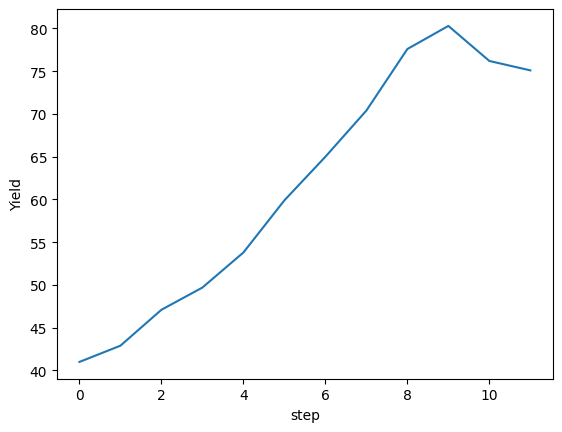

In [96]:
ax=March['y'].plot()
ax.set_xlabel("step")
ax.set_ylabel("Yield")

This is a pretty smooth curve and in reality, you probably should go a little bit more beyond the peak to make sure you are at the peak. But all you are trying to do is to find out approximately where the top of the 'hill' is. If your first experiment is not exactly right you might have gone off in the wrong direction!

You might want to do another first-order experiment just to be sure. Or, you might wish to do a second order experiment, assuming you are near the top. The second order experiment will help find a more exact location of the peak.

The point is, this is a fairly cheap way to 'scout around the mountain' to try to find where the optimum conditions are. Remember, this example is being shown in two dimensions but you may be working in three or four-dimensional space! You can use the same method, fitting a first-order model and then moving up the response surface in k dimensional space until you think you are close to where the optimal conditions are.

If you are in more than 2 dimensions, you will not be able to get a nice plot. But that is OK. The method of steepest ascent tells you where to take new measurements, and you will know the response at those points. You might move a few steps and you may see that the response continued to move up or perhaps not - then you might do another first order experiment and redirect your efforts. The point is, when we do the experiment for the second order model, we hope that the optimum will be in the range of the experiment - if it is not, we are extrapolating to find the optimum. In this case, the safest thing to do is to do another experiment around this estimated optimum. Since the experiment for the second order model requires more runs than experiments for the first order model, we want to move into the right region before we start fitting second-order models.


## Steepest Ascent - The Second Order Model

\begin{equation}
y=\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_{12} x_1 x_2 + \beta_{11} x_1^2 + \beta_{22} x_2^2 + \epsilon
\end{equation}


This second order model includes linear terms, cross product terms and a second order term for each of the x's.  If we generalize this to x's, we have first order terms, second order terms and then we have all possible pairwise first-order interactions. The linear terms just have one subscript. The quadratic terms have two subscripts. There are $\frac{k*(k-1)}{2} interaction terms. To fit this model, we are going to need a response surface design that has more runs than the first order designs used to move close to the optimum. 

This second order model is the basis for response surface designs under the assumption that although the hill is not a perfect quadratic polynomial in k dimensions, it provides a good approximation to the surface near the maximum or a minimum.

Assuming that we have 'marched up this hill' and if we re-specified the region of interest in our example, we are now between 80 - 90 in terms of time and 170 - 180 in terms of temperature. We would now translate these natural units into our coded units and if we fit the first order model again, hopefully we can detect that the middle is higher than the corner points so we would have curvature in our model, and could now fit a quadratic polynomial.

## Polynomial regression
Despite its name, linear regression can be used to fit non-linear functions. A linear regression model is linear in the model parameters, not necessarily in the predictors. If you add non-linear transformations of your predictors to the linear regression model, the model will be non-linear in the predictors.

In [102]:
res1 = smf.ols(formula='y ~ t + T + t:T + I(t**2) + I(T**2)', data=March).fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     78.67
Date:                Fri, 09 Jun 2023   Prob (F-statistic):           1.99e-06
Time:                        00:31:03   Log-Likelihood:                -31.008
No. Observations:                  12   AIC:                             68.02
Df Residuals:                       9   BIC:                             69.47
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     31.6455      3.826      8.271      0.0

C:\Users\petbr908\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
